In [1]:
!pip -q install gradio==4.* xgboost==2.* seaborn==0.13.* scikit-learn==1.* pandas==2.* matplotlib==3.* plotly==5.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
yfinance 0.2.66 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
google-genai 1.46.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incompatible.


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", context="notebook")

In [4]:
from google.colab import files
import pandas as pd
import numpy as np
from IPython.display import display, clear_output

# 1) Upload file
uploaded = files.upload()
if len(uploaded) == 0:
    raise ValueError("No file uploaded. Please upload a CSV/XLSX.")

fname = list(uploaded.keys())[0]
ext = fname.split(".")[-1].lower()

# 2) Read file
read_ok = False
df = None
try:
    if ext in ["csv", "txt"]:
        df = pd.read_csv(fname)
        read_ok = True
    elif ext in ["xlsx", "xls"]:
        df = pd.read_excel(fname)
        read_ok = True
except Exception as e:
    print("Primary read failed, retrying with different options:", e)

if not read_ok:
    try:
        df = pd.read_csv(fname, engine="python", encoding_errors="ignore")
        read_ok = True
    except Exception as e:
        raise ValueError(f"Could not read file {fname}. Error: {e}")

# 3) Clean column names (trim only; keep original cases for display)
df.columns = [c.strip() for c in df.columns]

print("Loaded data with shape:", df.shape)
display(df.head())

# 4) Auto-detect columns
def find_col(possible, cols):
    # Return first match from possible list that exists in cols (case-insensitive)
    lower_map = {c.lower(): c for c in cols}
    for p in possible:
        if p.lower() in lower_map:
            return lower_map[p.lower()]
    return None

possible_target = ["salary", "salary_in_usd", "annual_salary", "current_salary", "salaryusd", "compensation"]
possible_exp    = ["experience", "years_experience", "years of experience", "experience_years", "yearsofexperience", "years", "exp", "education-num"]
possible_edu    = ["education", "education_level", "highest_education", "degree", "qualification"]

target_col     = find_col(possible_target, list(df.columns))
experience_col = find_col(possible_exp, list(df.columns))
education_col  = find_col(possible_edu, list(df.columns))

print("\nAuto-detected columns:")
print("  target (salary):", target_col)
print("  experience:", experience_col)
print("  education:", education_col)

if target_col is None:
    raise ValueError("Could not detect the salary/target column. Rename it to 'salary' or set it below in the widget.")
if experience_col is None:
    raise ValueError("Could not detect the experience column. Rename it to 'experience' or set it below in the widget.")

# 5) Suggest extra numeric/categorical features
all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
all_categor = df.select_dtypes(include=["object", "category", "string"]).columns.tolist() if hasattr(pd, "StringDtype") else df.select_dtypes(include=["object", "category"]).columns.tolist()

excluded = {c for c in [target_col, experience_col, education_col] if c is not None}
default_extra_numeric = [c for c in all_numeric if c not in excluded and c != target_col]
default_extra_categor = [c for c in all_categor if c not in excluded]

# Default selections (works even if you skip the widget)
numeric_features = [experience_col] + default_extra_numeric
categorical_features = ([education_col] if education_col is not None else []) + default_extra_categor
feature_cols = numeric_features + categorical_features

print("\nDefault feature selection (you can change this below with the widget):")
print("  Numeric features:", numeric_features)
print("  Categorical features:", categorical_features)
print("  Target:", target_col)

# 6) Interactive selector (optional) — refine your choices
try:
    import ipywidgets as widgets

    col_names = list(df.columns)

    w_target = widgets.Dropdown(
        options=col_names, value=target_col, description="Target (salary):", layout=widgets.Layout(width="50%")
    )
    w_experience = widgets.Dropdown(
        options=col_names, value=experience_col, description="Experience:", layout=widgets.Layout(width="50%")
    )
    edu_options = [None] + col_names
    w_education = widgets.Dropdown(
        options=edu_options, value=education_col, description="Education:", layout=widgets.Layout(width="50%")
    )

    w_extra_numeric = widgets.SelectMultiple(
        options=[c for c in all_numeric if c not in {target_col, experience_col}],
        value=tuple(default_extra_numeric),
        description="Extra numeric",
        layout=widgets.Layout(width="50%", height="150px")
    )
    w_extra_categor = widgets.SelectMultiple(
        options=[c for c in all_categor if c != education_col],
        value=tuple(default_extra_categor),
        description="Extra categorical",
        layout=widgets.Layout(width="50%", height="150px")
    )

    btn_apply = widgets.Button(description="Apply selection", button_style="success")
    out = widgets.Output()

    def on_apply_clicked(b):
        with out:
            clear_output()
            # Set as globals so next cells can see them
            global target_col, experience_col, education_col, numeric_features, categorical_features, feature_cols

            target_col = w_target.value
            experience_col = w_experience.value
            education_col = w_education.value

            if target_col is None or experience_col is None:
                print("Please choose both target and experience columns.")
                return

            extra_num = list(w_extra_numeric.value)
            extra_cat = list(w_extra_categor.value)

            # Rebuild features
            numeric_features = [experience_col] + [c for c in extra_num if c != target_col and c != experience_col]
            categorical_features = ([education_col] if education_col is not None else []) + [c for c in extra_cat if c != education_col and c != target_col]
            feature_cols = numeric_features + categorical_features

            print("Selection applied!")
            print("  Target:", target_col)
            print("  Numeric features:", numeric_features)
            print("  Categorical features:", categorical_features)
            print("\nPreview of selected columns:")
            preview_cols = feature_cols + [target_col]
            display(df[preview_cols].head())

    btn_apply.on_click(on_apply_clicked)

    print("\nOptional: refine your selections, then click 'Apply selection'.")
    display(
        widgets.VBox([
            widgets.HBox([w_target, w_experience, w_education]),
            widgets.HBox([w_extra_numeric, w_extra_categor]),
            btn_apply,
            out
        ])
    )
except Exception as e:
    print("\nWidget UI could not be displayed. You can proceed with the default selections above or set variables manually.")
    print("Error:", e)

Saving salary.csv to salary (1).csv
Loaded data with shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



Auto-detected columns:
  target (salary): salary
  experience: education-num
  education: education

Default feature selection (you can change this below with the widget):
  Numeric features: ['education-num', 'age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
  Categorical features: ['education', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
  Target: salary

Optional: refine your selections, then click 'Apply selection'.


Shape: (32561, 15)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Descriptive stats (numeric):


,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0



Missing values summary:


,missing_count,missing_pct
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0



Duplicate rows: 24


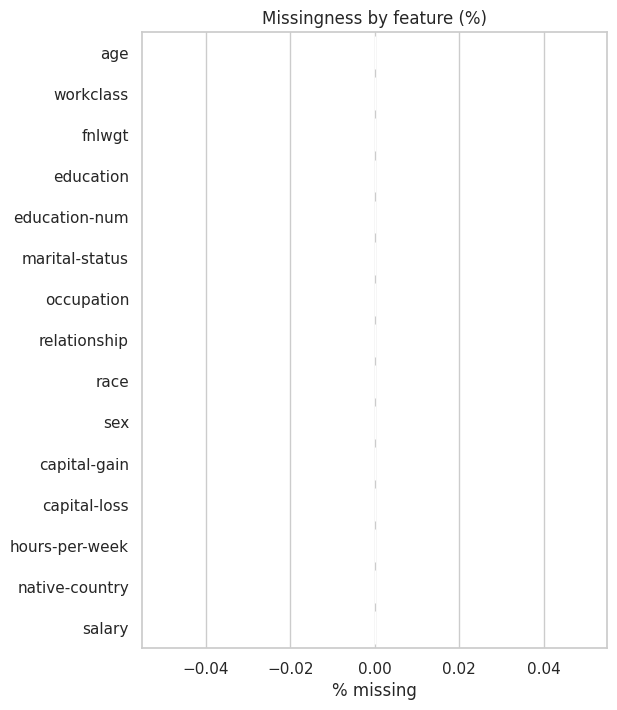

In [5]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nDescriptive stats (numeric):")
display(df.describe().T)

# Missing values report
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing_report = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct.round(2)})
print("\nMissing values summary:")
display(missing_report)

# Duplicates
dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

# Visual missingness
plt.figure(figsize=(6, 0.4*len(df.columns)+2))
miss_bar = (df.isna().mean()*100).sort_values(ascending=False)
sns.barplot(x=miss_bar.values, y=miss_bar.index, color="#1f77b4")
plt.title("Missingness by feature (%)")
plt.xlabel("% missing")
plt.ylabel("")
plt.show()

In [10]:
# Drop rows with missing target
before = df.shape[0]
df = df[~df[target_col].isna()].copy()
print(f"Dropped {before - df.shape[0]} rows with missing target '{target_col}'.")

# Remove duplicates
before = df.shape[0]
df = df.drop_duplicates().copy()
print(f"Removed {before - df.shape[0]} duplicate rows.")

# Convert target column to numerical (assuming binary classification <=50K vs >50K)
if df[target_col].dtype == 'object':
    print(f"Converting target column '{target_col}' from object to numerical.")
    # Strip whitespace before mapping
    df[target_col] = df[target_col].str.strip()
    # Map string values to numerical (e.g., 0 for <=50K, 1 for >50K)
    # Adjust mapping based on actual unique values if different
    unique_target_values = df[target_col].unique()
    if all(v in ['<=50K', '>50K'] for v in unique_target_values):
        df[target_col] = df[target_col].map({'<=50K': 0, '>50K': 1})
    else:
        print(f"Warning: Target column '{target_col}' has unexpected unique values: {unique_target_values}. Skipping conversion.")


# Basic sanity filters (edit thresholds as needed)
if experience_col in df.columns and pd.api.types.is_numeric_dtype(df[experience_col]):
    neg_exp = (df[experience_col] < 0).sum()
    if neg_exp > 0:
        print(f"Found {neg_exp} rows with negative experience. Clipping to 0.")
        df.loc[df[experience_col] < 0, experience_col] = 0
elif experience_col is not None:
    print(f"Warning: Experience column '{experience_col}' is not numeric. Skipping negative value check.")


if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
    neg_sal = (df[target_col] < 0).sum()
    if neg_sal > 0:
        print(f"Found {neg_sal} rows with negative salary. Dropping.")
        df = df[df[target_col] >= 0].copy()
elif target_col is not None:
     print(f"Warning: Target column '{target_col}' is not numeric after attempted conversion. Skipping negative value check.")


print("Cleaned shape:", df.shape)

Dropped 0 rows with missing target 'salary'.
Removed 0 duplicate rows.
Cleaned shape: (32537, 15)


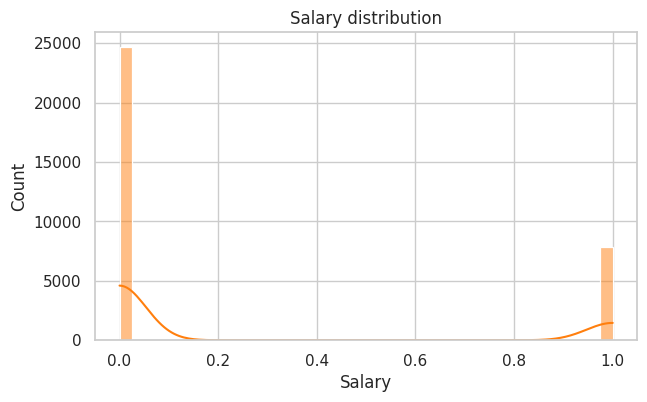

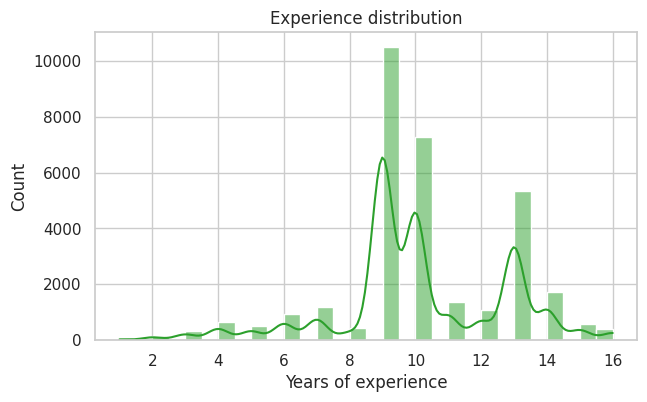

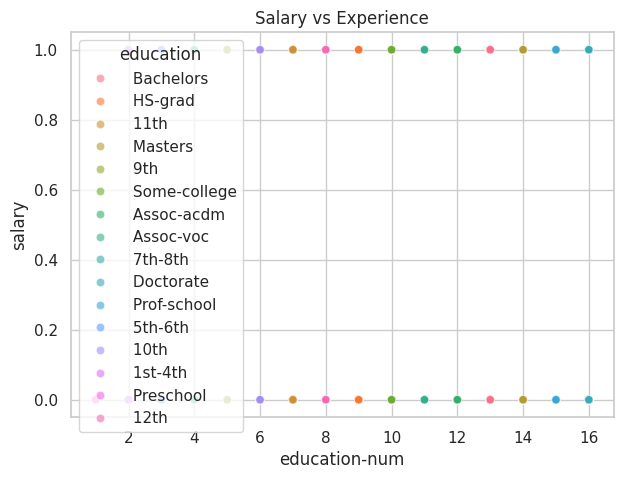

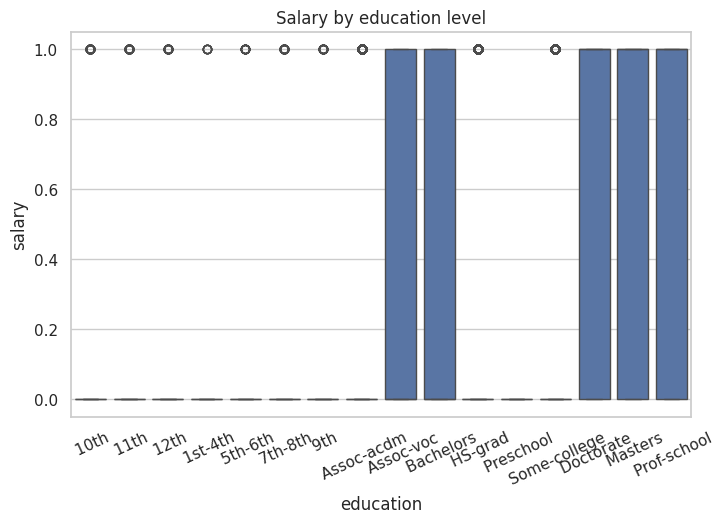

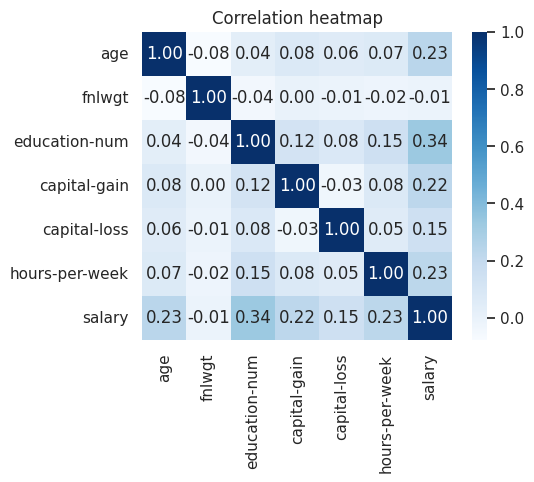

In [11]:
# Distribution of salary
plt.figure(figsize=(7,4))
sns.histplot(df[target_col], kde=True, bins=40, color="#ff7f0e")
plt.title("Salary distribution")
plt.xlabel("Salary")
plt.show()

# Experience distribution
plt.figure(figsize=(7,4))
sns.histplot(df[experience_col], kde=True, bins=30, color="#2ca02c")
plt.title("Experience distribution")
plt.xlabel("Years of experience")
plt.show()

# Salary vs Experience
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x=experience_col, y=target_col, hue=education_col if education_col in df.columns else None, alpha=0.6)
plt.title("Salary vs Experience")
plt.show()

# Salary by education
if education_col in df.columns:
    plt.figure(figsize=(8,5))
    order = df.groupby(education_col)[target_col].median().sort_values().index
    sns.boxplot(data=df, x=education_col, y=target_col, order=order)
    plt.title("Salary by education level")
    plt.xticks(rotation=25)
    plt.show()

# Correlation (numeric only)
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    plt.figure(figsize=(5,4))
    sns.heatmap(num_df.corr(), annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation heatmap")
    plt.show()

In [12]:
# Cell 7 — Define features, preprocessing pipeline (uses selections from Cell 3)

print("Using features from Cell 3")
print("  Numeric features:", numeric_features)
print("  Categorical features:", categorical_features)
print("  Target:", target_col)

# Features and target
feature_cols = numeric_features + categorical_features
X = df[feature_cols].copy()
y = df[target_col].copy()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

Using features from Cell 3
  Numeric features: ['education-num', 'age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
  Categorical features: ['education', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
  Target: salary


In [13]:
# Stratify by education if available to preserve distribution
if education_col in df.columns:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=X[education_col]
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (26029, 14) Test shape: (6508, 14)


Cross-validated performance (sorted by RMSE):


,model,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_r2_mean
5,XGBoost,0.303007,0.000020,0.196945,0.496195
4,Gradient Boosting,0.308644,0.000512,0.205997,0.477276
3,Random Forest,0.309816,0.001490,0.190262,0.473294
1,Ridge,0.341228,0.001087,0.264406,0.361079
2,Lasso,0.341239,0.001221,0.264873,0.361035
0,Linear Regression,0.341298,0.001077,0.264468,0.360817


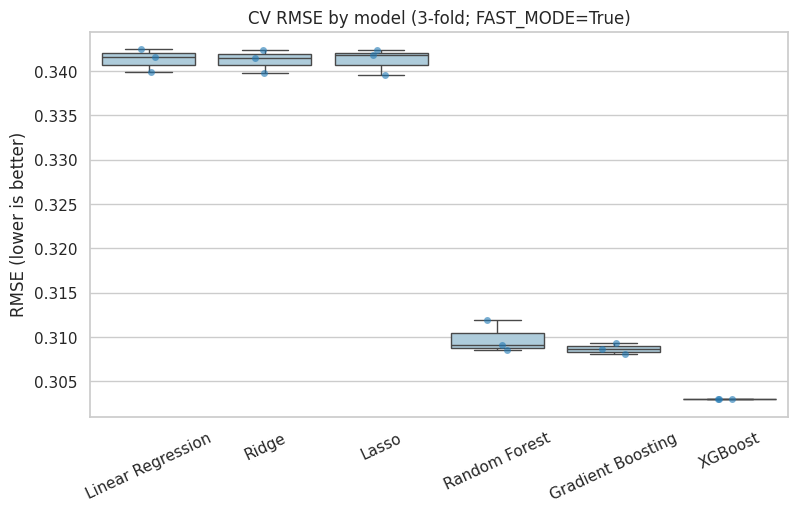

Best model by CV RMSE: XGBoost
CPU times: user 2min 4s, sys: 578 ms, total: 2min 4s
Wall time: 1min 20s


In [15]:
# Cell 9 — Model benchmarking (fast or full)
%%time
import subprocess
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Toggle
FAST_MODE = True            # set to False for full benchmark
N_FOLDS = 3 if FAST_MODE else 5
MAX_CV_ROWS = 50000         # if training set bigger than this, sample for CV to speed up

# Detect GPU for XGBoost
def has_gpu():
    try:
        out = subprocess.check_output(["bash", "-lc", "nvidia-smi -L"], stderr=subprocess.STDOUT).decode()
        return "GPU" in out
    except Exception:
        return False

USE_GPU_XGB = has_gpu()
xgb_tree_method = "gpu_hist" if USE_GPU_XGB else "hist"

# Build models (lighter configs in FAST_MODE)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),  # no random_state needed
    "Lasso": Lasso(alpha=0.0005, max_iter=10000),
    "Random Forest": RandomForestRegressor(
        n_estimators=150 if FAST_MODE else 400,
        max_depth=12 if FAST_MODE else None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "XGBoost": XGBRegressor(
        n_estimators=200 if FAST_MODE else 400,
        learning_rate=0.1 if FAST_MODE else 0.05,
        max_depth=4,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=RANDOM_STATE, tree_method=xgb_tree_method,
        n_jobs=-1, verbosity=0
    ),
}

# Optional: downsample for CV if very large
X_cv, y_cv = X_train, y_train
if len(X_train) > MAX_CV_ROWS:
    X_cv = X_train.sample(n=MAX_CV_ROWS, random_state=RANDOM_STATE)
    y_cv = y_train.loc[X_cv.index]
    print(f"CV on a sample of {len(X_cv):,} rows out of {len(X_train):,} (to speed up)")

cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}

results, cv_distributions = [], {}

# Important: avoid nested parallelism — run folds sequentially and let models use threads
for name, mdl in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", mdl)])
    scores = cross_validate(
        pipe, X_cv, y_cv, cv=cv, scoring=scoring,
        n_jobs=1,  # prevent CPU oversubscription
        return_train_score=False
    )
    rmse = -scores["test_rmse"]
    mae = -scores["test_mae"]
    r2 = scores["test_r2"]

    results.append({
        "model": name,
        "cv_rmse_mean": rmse.mean(),
        "cv_rmse_std": rmse.std(),
        "cv_mae_mean": mae.mean(),
        "cv_r2_mean": r2.mean()
    })
    cv_distributions[name] = rmse

cv_df = pd.DataFrame(results).sort_values(by="cv_rmse_mean")
print("Cross-validated performance (sorted by RMSE):")
display(cv_df)

plt.figure(figsize=(9,5))
rmse_plot = pd.DataFrame({k: v for k, v in cv_distributions.items()})
sns.boxplot(data=rmse_plot, color="#a6cee3")
sns.stripplot(data=rmse_plot, color="#1f78b4", alpha=0.6)
plt.ylabel("RMSE (lower is better)")
plt.title(f"CV RMSE by model ({N_FOLDS}-fold; FAST_MODE={FAST_MODE})")
plt.xticks(rotation=25)
plt.show()

best_model_name = cv_df.iloc[0]["model"]
print(f"Best model by CV RMSE: {best_model_name}")

In [16]:
DO_TUNING = False  # set True to run a small randomized search

if DO_TUNING:
    from sklearn.model_selection import RandomizedSearchCV
    import scipy.stats as st

    tuned_models = {}

    # Random Forest tuning
    rf_pipe = Pipeline([("preprocess", preprocessor), ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))])
    rf_params = {
        "model__n_estimators": st.randint(300, 800),
        "model__max_depth": st.randint(3, 20),
        "model__min_samples_split": st.randint(2, 10),
        "model__min_samples_leaf": st.randint(1, 5),
        "model__max_features": ["auto", "sqrt", 0.7, 0.9]
    }
    rf_search = RandomizedSearchCV(rf_pipe, rf_params, n_iter=25, scoring="neg_root_mean_squared_error",
                                   cv=5, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
    rf_search.fit(X_train, y_train)
    tuned_models["Random Forest (tuned)"] = rf_search.best_estimator_
    print("RF best params:", rf_search.best_params_)

    # XGBoost tuning
    xgb_pipe = Pipeline([("preprocess", preprocessor), ("model", XGBRegressor(random_state=RANDOM_STATE, tree_method="hist"))])
    xgb_params = {
        "model__n_estimators": st.randint(300, 900),
        "model__learning_rate": st.uniform(0.01, 0.2),
        "model__max_depth": st.randint(3, 8),
        "model__subsample": st.uniform(0.6, 0.4),
        "model__colsample_bytree": st.uniform(0.6, 0.4),
        "model__reg_lambda": st.uniform(0.5, 2.0)
    }
    xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=30, scoring="neg_root_mean_squared_error",
                                    cv=5, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
    xgb_search.fit(X_train, y_train)
    tuned_models["XGBoost (tuned)"] = xgb_search.best_estimator_
    print("XGB best params:", xgb_search.best_params_)

    # Compare tuned models
    tuned_scores = []
    for name, est in tuned_models.items():
        cv_scores = cross_validate(est, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        tuned_scores.append({
            "model": name,
            "cv_rmse_mean": (-cv_scores["test_rmse"]).mean(),
            "cv_mae_mean": (-cv_scores["test_mae"]).mean(),
            "cv_r2_mean": (cv_scores["test_r2"]).mean()
        })
    tuned_df = pd.DataFrame(tuned_scores).sort_values(by="cv_rmse_mean")
    print("Tuned model performance:")
    display(tuned_df)

    if tuned_df.iloc[0]["cv_rmse_mean"] < cv_df.iloc[0]["cv_rmse_mean"]:
        best_model_name = tuned_df.iloc[0]["model"]
        best_estimator = tuned_models[best_model_name]
    else:
        # fall back to best from untuned models
        best_estimator = Pipeline([("preprocess", preprocessor), ("model", models[best_model_name])])
else:
    best_estimator = Pipeline([("preprocess", preprocessor), ("model", models[best_model_name])])

Best model: XGBoost
Test MAE:  0.19
Test RMSE: 0.30
Test R²:   0.5207


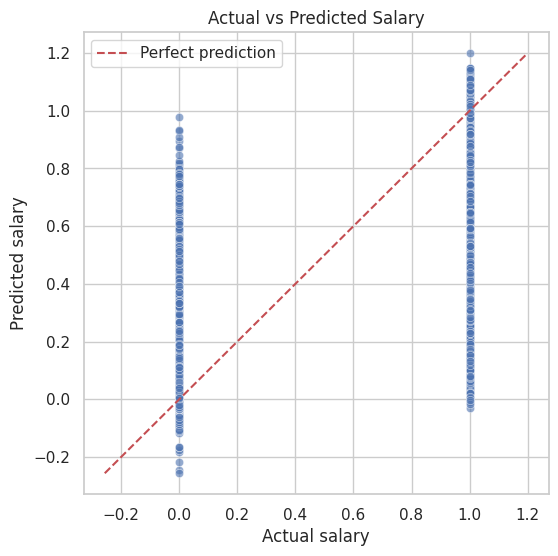

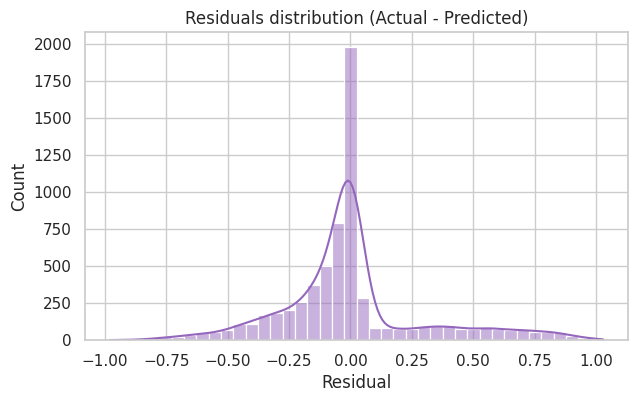

In [18]:
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

print(f"Best model: {best_model_name}")
print(f"Test MAE:  {test_mae:,.2f}")
print(f"Test RMSE: {test_rmse:,.2f}")
print(f"Test R²:   {test_r2:.4f}")

# Parity plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--", label="Perfect prediction")
plt.xlabel("Actual salary")
plt.ylabel("Predicted salary")
plt.title("Actual vs Predicted Salary")
plt.legend()
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(7,4))
sns.histplot(residuals, kde=True, bins=40, color="#9467bd")
plt.title("Residuals distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.show()

In [19]:
# Save the trained model + metadata for UI
import joblib
MODEL_PATH = "best_salary_model.joblib"

# Derive defaults for UI
cat_levels_map = {}
for c in categorical_features:
    cat_levels_map[c] = sorted(X_train[c].dropna().astype(str).unique().tolist())

num_defaults_map = {}
for c in numeric_features:
    try:
        num_defaults_map[c] = float(np.nanmedian(X_train[c]))
    except Exception:
        num_defaults_map[c] = 0.0

joblib.dump({
    "pipeline": best_estimator,
    "feature_cols": feature_cols,
    "target_col": target_col,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "experience_col": experience_col,
    "education_col": education_col,
    "cat_levels_map": cat_levels_map,
    "num_defaults_map": num_defaults_map
}, MODEL_PATH)
print("Saved model to:", MODEL_PATH)

Saved model to: best_salary_model.joblib


In [20]:
# Dynamic Gradio app for all selected features
import gradio as gr
import joblib
import numpy as np
import pandas as pd

bundle = joblib.load("best_salary_model.joblib")
pipe = bundle["pipeline"]
feature_cols = bundle["feature_cols"]
numeric_features = bundle["numeric_features"]
categorical_features = bundle["categorical_features"]
experience_col = bundle["experience_col"]
education_col = bundle["education_col"]
cat_levels_map = bundle["cat_levels_map"]
num_defaults_map = bundle["num_defaults_map"]

# Build inputs in a consistent order (experience first if present)
inputs = []
order = []

if experience_col in numeric_features:
    inputs.append(gr.Number(label=f"{experience_col} (numeric)", value=float(num_defaults_map.get(experience_col, 3.0)), precision=1))
    order.append(experience_col)

# other numeric
for c in [c for c in numeric_features if c != experience_col]:
    inputs.append(gr.Number(label=f"{c} (numeric)", value=float(num_defaults_map.get(c, 0.0))))
    order.append(c)

# categorical
for c in categorical_features:
    choices = cat_levels_map.get(c, [])
    default = choices[0] if len(choices) else None
    inputs.append(gr.Dropdown(choices=choices, value=default, label=f"{c} (categorical)"))
    order.append(c)

def predict_fn(*vals):
    row = {col: vals[i] for i, col in enumerate(order)}
    X_infer = pd.DataFrame([row])[feature_cols]  # missing cols will be NaN and imputed
    pred = float(pipe.predict(X_infer)[0])
    return f"Estimated salary: {pred:,.0f}"

demo = gr.Interface(
    fn=predict_fn,
    inputs=inputs,
    outputs=gr.Textbox(label="Prediction"),
    title="Employee Salary Predictor",
    description="Enter features to estimate salary."
)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9a791ec3f1c3dfd7c4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
